In [1]:
import copy
import glob
import numpy as np
import os
import pandas as pd
import scipy
import scipy.stats
import tqdm
import warnings

In [2]:
import yt
import trident
import unyt

In [3]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use( '/Users/zhafen/repos/clean-bold/clean-bold.mplstyle' )
import palettable

# Parameters

In [4]:
pm = {
    'broaden_models': True,
    'weighting': 'density',
    'sim_weighting': 'column_density',
}

In [5]:
redshift = 0.13

In [6]:
data_dir = './data/modeling_results/sameer_charlton/sample2'
ray_dir = './data/synthetic_data/sample2/rays'

In [7]:
# Plotting parameters
cmap = palettable.cartocolors.qualitative.Safe_10.mpl_colors

# Load Data

In [8]:
# Get sightline filepaths
sl_fps = []
sls = []
for sl_fp in glob.glob( os.path.join( data_dir, '*' ) ):
    sl_fps.append( sl_fp )
    sls.append( os.path.split( sl_fp )[-1] )

In [9]:
# Get rays
ray_fps = [ os.path.join( ray_dir, 'ray_{}.h5'.format( _[1:] ) ) for _ in sls ]
rays = [ yt.load( _ ) for _ in ray_fps ]

yt : [INFO     ] 2022-01-26 16:45:40,849 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-01-26 16:45:40,851 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2022-01-26 16:45:40,852 Parameters: domain_left_edge          = [0. 0. 0.] kpc
yt : [INFO     ] 2022-01-26 16:45:40,854 Parameters: domain_right_edge         = [95.7322 95.7322 95.7322] kpc
yt : [INFO     ] 2022-01-26 16:45:40,854 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2022-01-26 16:45:40,915 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-01-26 16:45:40,917 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2022-01-26 16:45:40,918 Parameters: domain_left_edge          = [0. 0. 0.] kpc
yt : [INFO     ] 2022-01-26 16:45:40,919 Parameters: domain_right_edge         = [95.7322 95.7322 95.7322] kpc
yt : [INFO     ] 2022-01-26 16:45:40,920 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2022-01-26 16:45:40,974 Parameters: current_time   

# Plot

## Setup

### Parameters

In [10]:
n_sample_turb = 1000
n_bins = 20
n_bins = 64

In [11]:
contour_levels = [ 90, 50 ]
contour_linewidths = [ 1, 3 ]

In [12]:
mosaic = [
    [ 'vlos', '.', '.', '.' ],
    [ 'T_vlos', 'T', '.', '.' ],
    [ 'nH_vlos', 'nH_T', 'nH', '.' ],
    [ 'Z_vlos', 'Z_T', 'Z_nH', 'Z', ],
]

In [13]:
labels = {
    'vlos': r'$v_{\rm LOS}$ [km/s]',
    'T': r'T [K]',
    'nH': r'$n_{\rm H}$ [cm$^{-3}$]',
    'Z': r'$Z$ [$Z_{\odot}$]',
}

In [14]:
lims = {
    'vlos': [ -100, 100 ],
    'T': [ 1e2, 2.5e6 ],
    'nH': [ 1e-7, 100 ],
    'Z': [ 1e-3, 30 ],
}
autolims = {
    'vlos': True,
    'T': True,
    'nH': True,
    'Z': True,
}

In [15]:
dvs = {
    'vlos': 5.,
    'T': 0.05,
    'nH': 0.05,
    'Z': 0.05,
}

In [16]:
logscale = {
    'vlos': False,
    'T': True,
    'nH': True,
    'Z': True,
}

In [17]:
def one_color_linear_cmap( color, name, f_white=0.95, f_saturated=1.0, ):
    '''A function that turns a single color into linear colormap that
    goes from a color that is whiter than the original color to a color
    that is more saturated than the original color.
    '''
    
    color_hsv = matplotlib.colors.rgb_to_hsv( color )
    start_color_hsv = copy.copy( color_hsv )
    
    start_color_hsv = copy.copy( color_hsv )
    start_color_hsv[1] -= f_white * start_color_hsv[1]
    start_color_hsv[2] += f_white * ( 1. - start_color_hsv[2] )
    start_color = matplotlib.colors.hsv_to_rgb( start_color_hsv )
    
    end_color_hsv = copy.copy( color_hsv )
    end_color_hsv[1] += f_saturated * ( 1. - end_color_hsv[1] )
    end_color = matplotlib.colors.hsv_to_rgb( end_color_hsv )
    
    return matplotlib.colors.LinearSegmentedColormap.from_list( name, [ start_color, end_color ] )

In [18]:
color_modeled = cmap[0]
color_data = cmap[1]
cmap_modeled = one_color_linear_cmap( color_modeled, 'modeled' )
cmap_data = one_color_linear_cmap( color_data, 'data' )
cmap_data = matplotlib.colors.LinearSegmentedColormap.from_list( 'data', [ 'w', color_data ] )

In [19]:
panel_length = 4.

### Other Setup

In [20]:
prop_keys = list( labels.keys() )

In [21]:
def zeff_to_vel( zeff ):
    
    ainv2 = ( ( 1. + zeff ) / ( 1. + redshift ) )**2.
    
    v_div_c = ( ainv2 - 1. ) / ( ainv2 + 1. )
    return ( v_div_c * unyt.c ).to( 'km/s' )

In [22]:
class ContourCalc( object ):
    
    def __init__( self, arr ):
        
        self.values_sorted = np.sort( arr.flatten() )[::-1]
        
        self.values_fraction = np.cumsum( self.values_sorted )
        self.values_fraction /= self.values_fraction[-1]
        
        self.interp_fn = scipy.interpolate.interp1d( self.values_fraction, self.values_sorted )
        
    def get_level( self, q ):
        
        f = np.array( q ) / 100.
        
        f_min = 0.5 * ( self.values_fraction[0] + self.values_fraction[1] )
        
        if pd.api.types.is_list_like( f ):
            f = np.array( f )
            f[f<f_min] = f_min
        else:
            if f < f_min:
                f = f_min

        return self.interp_fn( f ) 

## Plot

yt : [INFO     ] 2022-01-26 16:45:49,931 Allocating for 1.024e+03 particles



Making comparison for ray 0



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.47s/it]


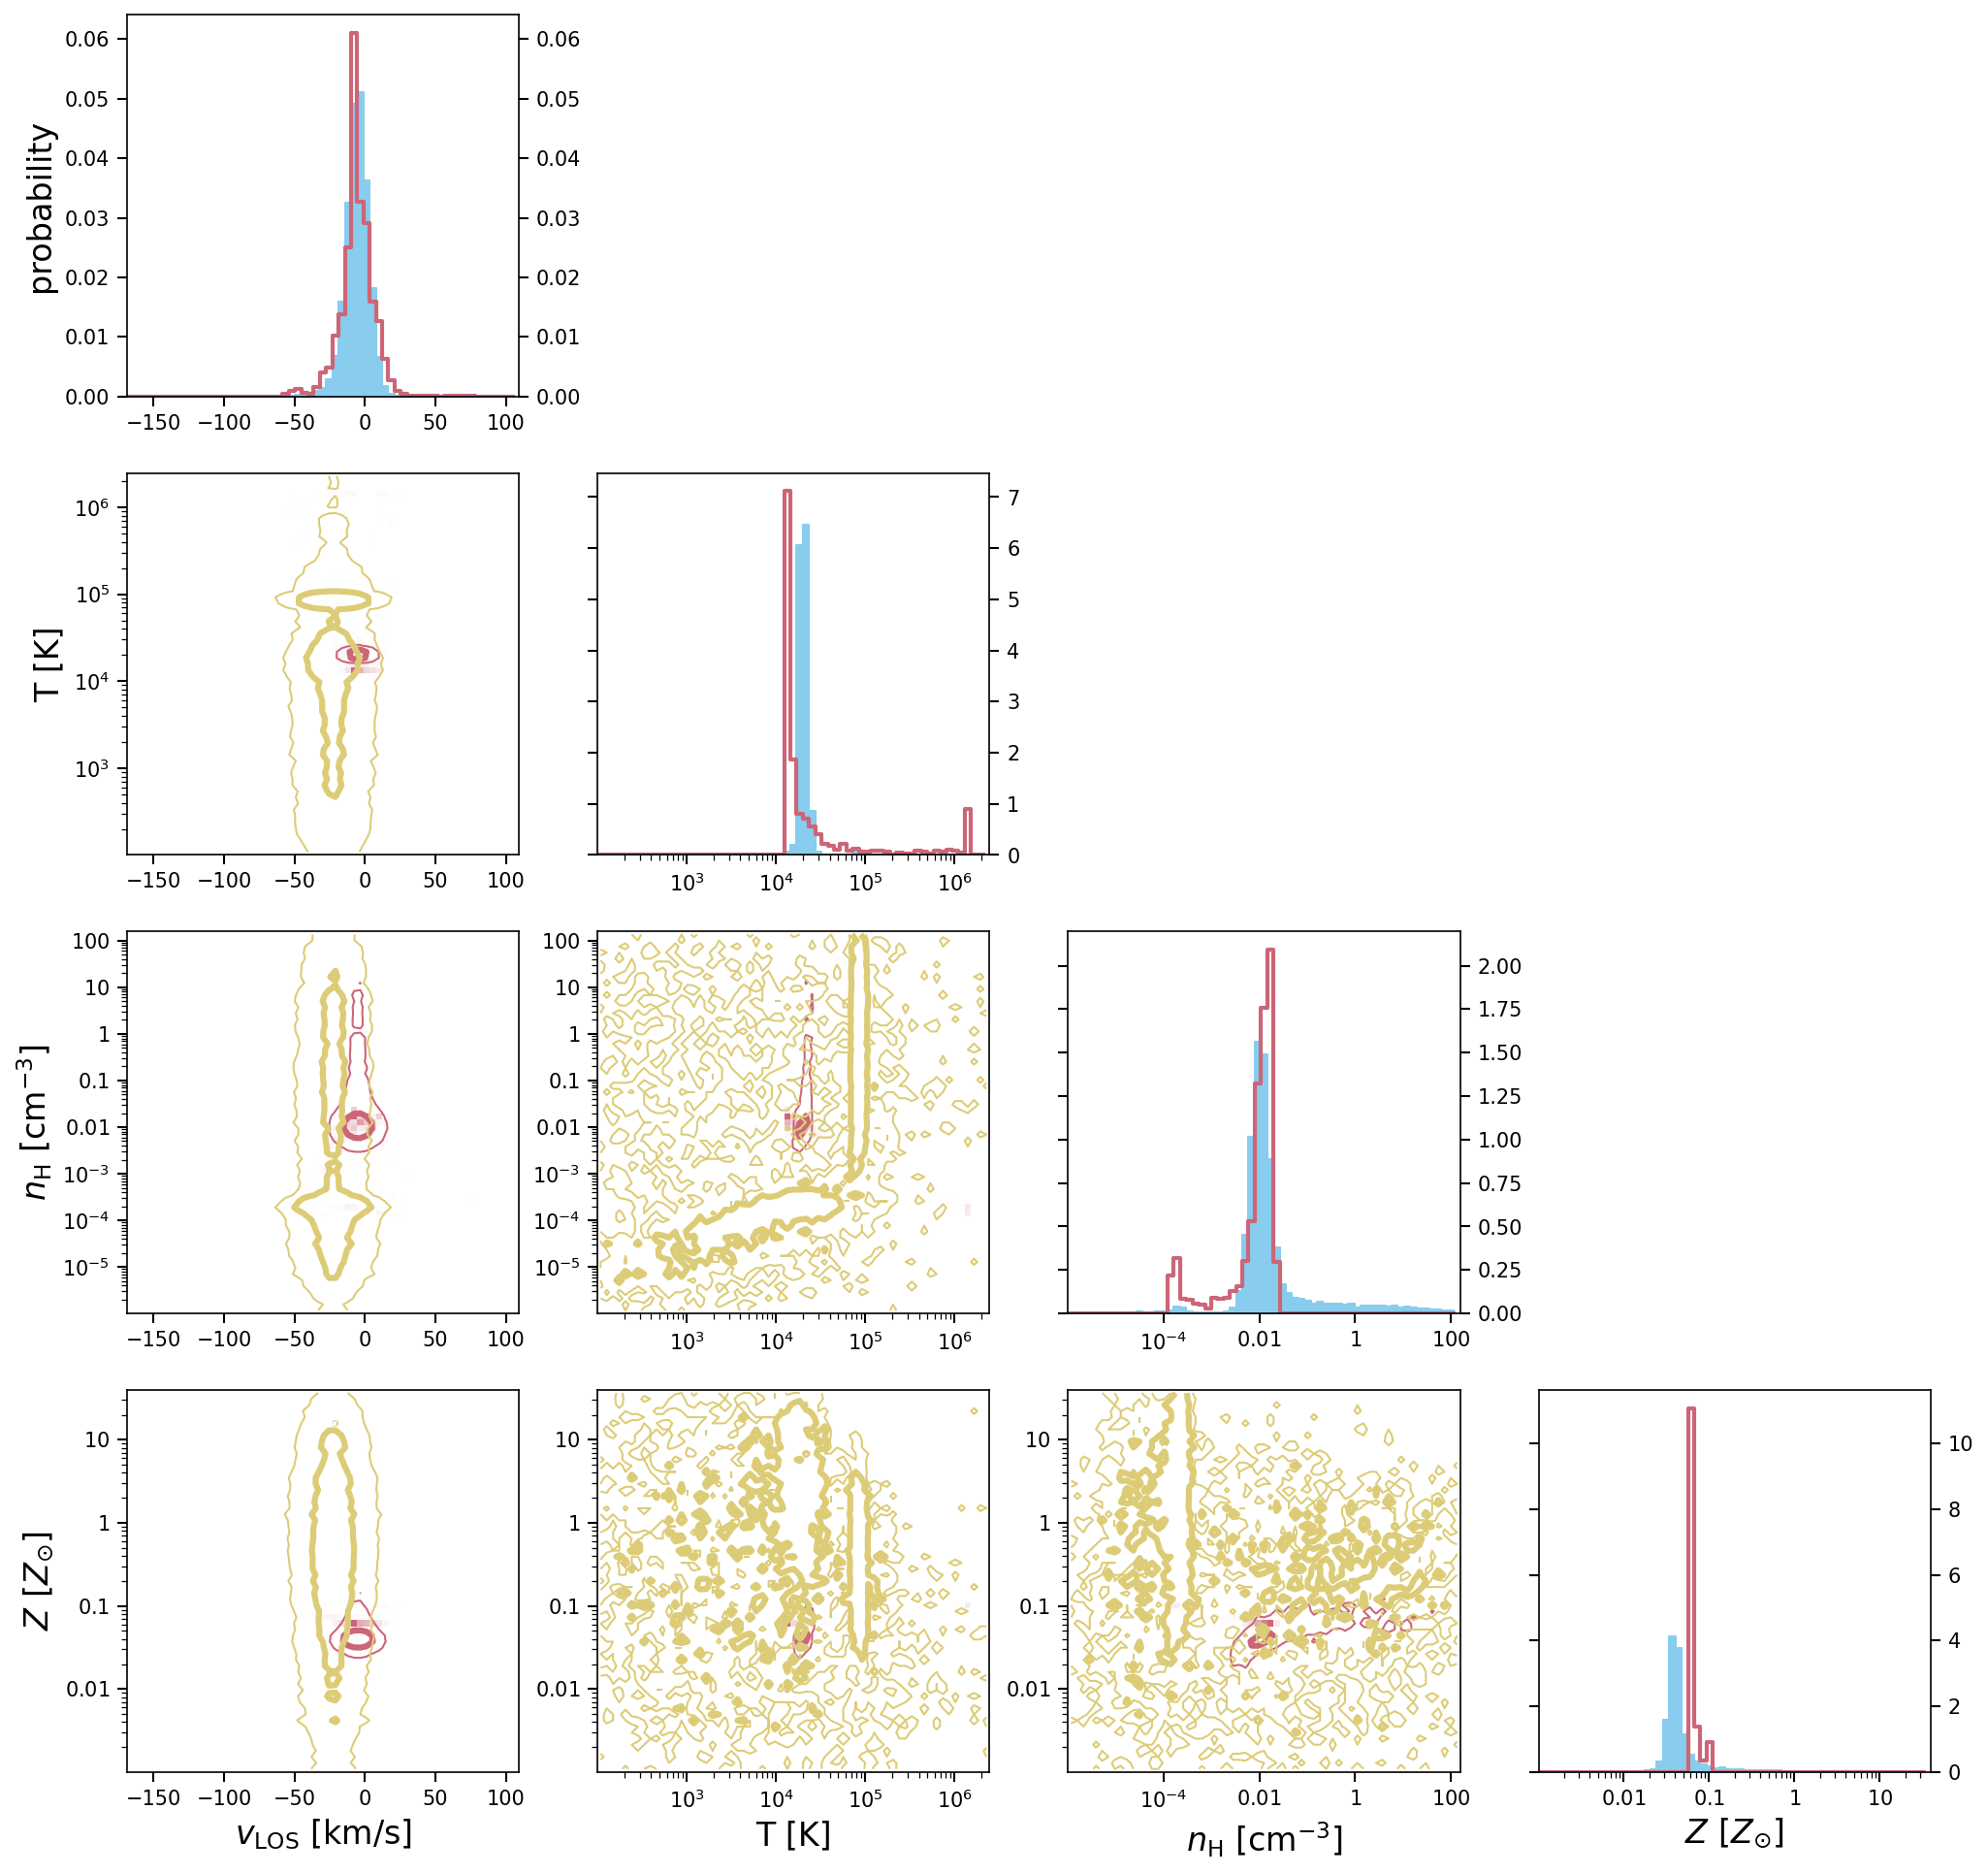

In [24]:
for i, ray in enumerate( rays ):
    
    # DEBUG
    if i > 0:
        continue
    
    print( '\nMaking comparison for ray {}\n'.format( i ) )

    # Ray properties
    den = ray.r[('gas', 'number_density')] * 0.75
    ray_data = {
        'nH': den,
        'NH': ( den * ray.r[('gas', 'dl')] ),
        'z': ray.r[('gas', 'redshift_eff')],
        'T': ray.r[('gas', 'temperature')],
        'Z': ray.r[('gas', 'metallicity')],
    }
    ray_data['vlos'] = zeff_to_vel( ray_data['z'] )

    # Modeled sightline
    sl = sls[i]
    sl_fp = sl_fps[i]

    # Get text files
    sl_data = {}
    col_names = [ 'prob', 'likelihood', 'Z', 'nH', 'T', 'NHI', 'bturb', 'z', ]
    col_units = [ 1., 1., unyt.Zsun, unyt.cm**-3, unyt.K, unyt.cm**-2, unyt.km / unyt.s, 1. ]
    for component_fp in glob.glob( os.path.join( sl_fp, '*' ) ):
        component_key = os.path.splitext( os.path.split( component_fp )[-1] )[0]
        sl_data[component_key] = pd.read_csv( component_fp, sep=' ', names=col_names )

    # Add LOS velocity and reformat
    for component_key, df in sl_data.items():

        # Reformat
        new_entry = {}
        for name in col_names:
            values = unyt.unyt_array( df[name].values )
            if name in [ 'nH', 'T', 'Z', 'NHI', ]:
                new_entry[name] = 10.**values
            else:
                new_entry[name] = values

        # Add LOS velocity
        new_entry['vlos'] = zeff_to_vel( df['z'].values )

        # Setup units
        for j, name in enumerate( col_names ):
            new_entry[name] *= col_units[j]

        sl_data[component_key] = new_entry

    col_names.append( 'vlos' )

    # Turn samples into histograms, formatted for a violin plot
    keys = list( sl_data.keys() )
    sl_formatted = {}
    sl_hists = {}
    for name in col_names:
        sl_formatted[name] = [ sl_data[_][name] for _ in keys ]
        sl_hists[name] = [
            np.histogram( _, bins=64 )
            for _ in sl_formatted[name]
        ]

    # Generate modeled sample to plot ("generate" because we're sampling the doppler broadening)
    if pm['broaden_models']:
        sl_tiled = {}
        for name in col_names:
            sl_tiled[name] = []

        for j, vlos_j in enumerate( tqdm.tqdm( sl_formatted['vlos'] ) ):
            sample_dist = scipy.stats.norm( loc=vlos_j, scale=sl_formatted['bturb'][j]/np.sqrt( 2. ) )
            sampled_values = sample_dist.rvs( ( n_sample_turb, vlos_j.size ) )

            for name in col_names:
                if name != 'vlos':
                    arr_tiled = np.hstack( np.tile( sl_formatted[name][j], ( n_sample_turb, 1 ),  ) )
                else:
                    arr_tiled = np.hstack( sampled_values )

                arr_tiled *= sl_formatted[name][j].units

                sl_tiled[name].append( arr_tiled )

        sl_used = sl_tiled
    else:
        sl_used = sl_formatted

    # Minimum weighting is to make sure no component is overweighted due to number of samples
    n_samples_max = np.max([ _.size for _ in sl_used['nH'] ])
    if pm['weighting'] is None:
        model_weights = [ np.full( _.size, n_samples_max / _.size ) for _ in sl_used['nH'] ]
    if pm['weighting'] == 'density':
        model_weights = [ np.full( _.size, np.nanmedian( _ ) * n_samples_max / _.size ) for _ in sl_used['nH'] ]
    stacked_weights = np.hstack( model_weights )

    sl_stacked = {}
    for key, item in sl_used.items():
        sl_stacked[key] = np.hstack( item ) * item[0].units

    # Get the weights for the ray
    if pm['sim_weighting'] is None:
        weights = np.ones( ray_data['NH'].shape )
    if pm['weighting'] == 'density':
        weights = copy.copy( ray_data['NH'].value )
        weights[np.isclose(weights,0.)] = np.nan

    bins = {}
    for key, item in lims.items():
        if autolims[key]:
            low = np.nanmin(np.hstack([ sl_stacked[key], ray_data[key] ]))
            high = np.nanmax(np.hstack([ sl_stacked[key], ray_data[key] ]))
        else:
            low = item[0]
            high = item[1]
        if logscale[key]:
            bins[key] = np.logspace( np.log10( low ), np.log10( high ), n_bins )
        else:
            bins[key] = np.linspace( low, high, n_bins )

        bins[key] *= sl_stacked[key].units

    dx = {}
    for key, bins_j in bins.items():

        if logscale[key]:
            dx[key] = np.log10( bins_j[1] ) - np.log10( bins_j[0] )
        else:
            dx[key] = float( ( bins_j[1] - bins_j[0] ).value )

    centers = {}
    for key, bins_j in bins.items():

        if logscale[key]:
            bins_j = np.log10( bins_j )

        centers[key] = bins_j[:-1] + 0.5 * np.diff( bins_j )

        if logscale[key]:
            centers[key] = 10.**centers[key]

    # Setup Figure
    n_cols = len( prop_keys )
    fig = plt.figure( figsize=( panel_length*n_cols, panel_length*n_cols ), )
    ax_dict = fig.subplot_mosaic( mosaic )

    # Loop through all properties
    for j, x_key in enumerate( tqdm.tqdm( prop_keys ) ):
        for k, y_key in enumerate( prop_keys ):

            # Avoid duplicates
            if k < j:
                continue

            # Check for out-of-bounds
            oob_labels = [ 'modeled', 'ray' ]
            for ii, key in enumerate([ x_key, y_key ]):
                for jj, values in enumerate([ sl_stacked[key], ray_data[key] ]):
                    n_low = ( values < bins[key][0] ).sum()
                    n_high = ( values > bins[key][-1] ).sum()
                    bounds = [ 'below', 'above' ]
                    for kk, n_oob in enumerate([ n_low, n_high ]):
                        if n_oob > 0:
                            warnings.warn(
                                '{} {} points ({:.2g}%) with {} {} {:.3g}'.format(
                                    n_oob,
                                    oob_labels[jj],
                                    n_oob / values.size * 100,
                                    key,
                                    bounds[kk],
                                    lims[key][kk],
                                )
                            )

            # 1D histogram
            if j == k:
                ax = ax_dict[x_key]
                subplotspec = ax.get_subplotspec()

                x_label = labels[x_key]
                y_label = 'probability'

                # Observational
                hist_o, edges = np.histogram(
                    sl_stacked[x_key],
                    bins = bins[x_key],
                    weights = stacked_weights,
                    density = False,
                )
                hist_o /= hist_o.sum() * dx[x_key]
                ax.fill_between(
                    edges[:-1],
                    hist_o,
                    color = color_modeled,
                    step = 'post',
                )

                # Ray
                hist_r, edges = np.histogram(
                    ray_data[x_key],
                    bins = bins[x_key],
                    weights = weights,
                    density = False,
                )
                hist_r /= hist_r.sum() * dx[x_key]
                ax.step(
                    edges[:-1],
                    hist_r,
                    color = color_data,
                    where = 'post',
                    linewidth = 2,
                )

                y_max = np.nanmax([ hist_r, hist_o ])
                ax.set_ylim( 0, y_max * 1.05 )
                ax.set_xlim( bins[x_key][0], bins[x_key][-1] )

                if logscale[x_key]:
                    ax.set_xscale( 'log' )

                ax.tick_params(
                    which = 'both',
                    labelleft = subplotspec.is_first_col(),
                    right = True,
                    labelright = True,
                )

            # 2D histogram
            else:
                try:
                    ax = ax_dict['{}_{}'.format( x_key, y_key )]
                except KeyError:
                    ax = ax_dict['{}_{}'.format( y_key, x_key )]
                subplotspec = ax.get_subplotspec()

                # Construct histograms to plot
                # Total modeled
                norm = stacked_weights.sum() * dx[x_key] * dx[y_key]
                hist2d_o, x_edges, y_edges = np.histogram2d(
                    sl_stacked[x_key],
                    sl_stacked[y_key],
                    bins = [ bins[x_key], bins[y_key], ],
                    weights = stacked_weights / norm,
                )
                img_arr_o = np.transpose( hist2d_o )
                # Per component
                img_arr_comps = []
                for kk, sl_used_x in enumerate( sl_used[x_key] ):
                    norm_kk = model_weights[kk].sum() * dx[x_key] * dx[y_key]
                    hist2d_kk, x_edges, y_edges = np.histogram2d(
                        sl_used_x,
                        sl_used[y_key][kk],
                        bins = [ bins[x_key], bins[y_key], ],
                        weights = model_weights[kk] / norm_kk,
                    )
                    img_arr_kk = np.transpose( hist2d_kk )
                    img_arr_comps.append( img_arr_kk )
                    
                # Ray
                used_weights = weights / ( weights.sum() * dx[x_key] * dx[y_key] )
                hist2d_r, x_edges, y_edges = np.histogram2d(
                    ray_data[x_key],
                    ray_data[y_key],
                    bins = [ bins[x_key], bins[y_key], ],
                    weights = used_weights,
                )
                img_arr_r = np.transpose( hist2d_r )

                # Plot
#                 ax.pcolormesh(
#                     centers[x_key],
#                     centers[y_key],
#                     img_arr_o,
#                     cmap = cmap_modeled,
#                     shading = 'nearest',
#                 )
                ax.pcolormesh(
                    centers[x_key],
                    centers[y_key],
                    img_arr_r,
                    cmap = cmap_data,
                    shading = 'nearest',
                )
                
#                 c_calc_o = ContourCalc( img_arr_o )
#                 levels = c_calc_o.get_level( contour_levels )
#                 ax.contour(
#                     centers[x_key],
#                     centers[y_key],
#                     img_arr_o,
#                     levels,
#                     colors = [ color_modeled, ] * len( levels ),
#                     linewidths = contour_linewidths,
#                 )
                for kk, img_arr_kk in enumerate( img_arr_comps ):
                    c_calc_kk = ContourCalc( img_arr_kk )
                    levels = c_calc_kk.get_level( contour_levels )
                    if kk == 0:
                        cmap_kk = kk
                    else:
                        cmap_kk = kk + 1
                    ax.contour(
                        centers[x_key],
                        centers[y_key],
                        img_arr_kk,
                        levels,
                        colors = [ cmap[kk+1], ] * len( levels ),
                        linewidths = contour_linewidths,
                    )

                ax.set_xlim( bins[x_key][0], bins[x_key][-1] )
                ax.set_ylim( bins[y_key][0], bins[y_key][-1] )

                if logscale[x_key]:
                    ax.set_xscale( 'log' )
                if logscale[y_key]:
                    ax.set_yscale( 'log' )

                x_label = labels[x_key]
                y_label = labels[y_key]

            if subplotspec.is_last_row():
                ax.set_xlabel( x_label, fontsize=16 )
            if subplotspec.is_first_col():
                ax.set_ylabel( y_label, fontsize=16 )

    # Save
    savedir = './figures/sample2/comparison'
    if pm['weighting'] == 'density':
        savedir = os.path.join( savedir, 'density_weighting' )
    os.makedirs( savedir, exist_ok=True )
    savefile = 'sightline_{}.png'.format( os.path.basename( sl_fps[i] ) )
    save_fp = os.path.join( savedir, savefile )
    plt.savefig( save_fp, bbox_inches='tight' )
    
#     plt.close()